# Convolutional Neural Networks

### Importing Libraries

In [1]:
import Pkg
Pkg.add("DataFrames")
Pkg.add("Flux")
Pkg.add("MLJ")
Pkg.add("CUDA")
Pkg.add("IterTools")
Pkg.add("ProgressMeter")
Pkg.add("Images")
Pkg.add("Augmentor")
Pkg.add("Glob")
Pkg.add("MLUtils")
Pkg.add("ImageShow")
Pkg.add("Statistics")

    Updating registry at `C:\Users\Steven\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\Steven\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  N

In [2]:
using DataFrames
using Flux
using MLJ
using CUDA
using IterTools: ncycle
using ProgressMeter
using Images
using Glob
using MLUtils
using Augmentor
using CUDA: CuIterator
using ImageShow
using Statistics

## Part 1 - Data Preprocessing

#### Check out our data

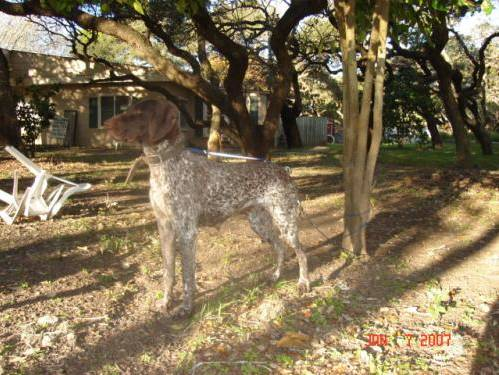

In [3]:
dog_img_path = "../data/catsndogs/training_set/dogs/dog.1992.jpg"

dog_img = Images.load(dog_img_path)

In [4]:
size(dog_img)

(375, 499)

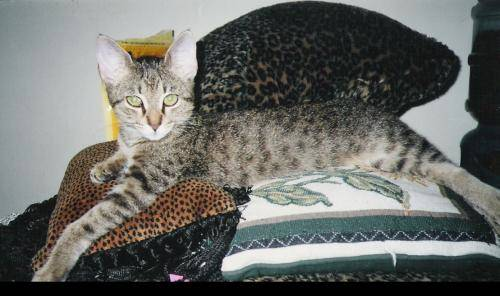

In [5]:
cat_img_path = "../data/catsndogs/training_set/cats/cat.2701.jpg"

cat_img = Images.load(cat_img_path)

#### Look at them side by side

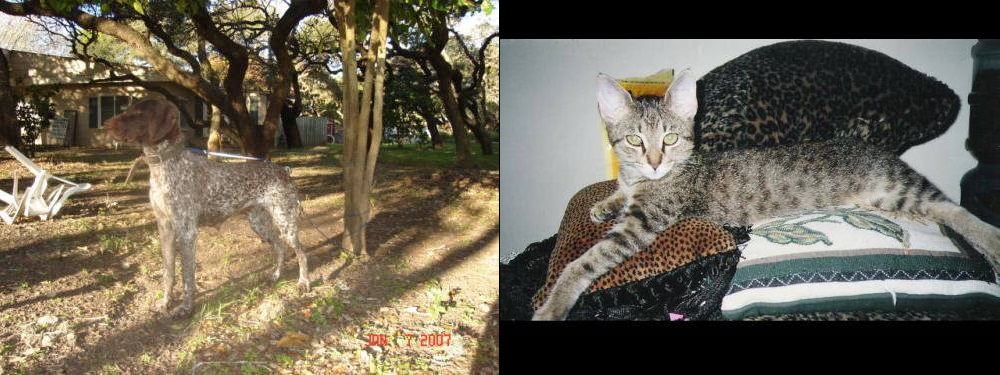

In [6]:
mosaicview(dog_img, cat_img; nrow=1)

In [47]:
@show typeof(dog_img)
@show size(dog_img)

@show typeof(cat_img)
@show size(cat_img)

typeof(dog_img) = Matrix{RGB{N0f8}}
size(dog_img) = (375, 499)
typeof(cat_img) = Matrix{RGB{N0f8}}
size(cat_img) = (296, 500)


(296, 500)

In [8]:
@show typeof(dog_img)
@show size(dog_img)

(296, 500)

In [9]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
BATCH_SIZE = 32

32

#### Importing the Datasets

#### Training Set

In [10]:
training_image_filenames = readdir(glob"*/*.jpg", "../data/catsndogs/training_set/")

8000-element Vector{String}:
 "../data/catsndogs/training_set/cats\\cat.1.jpg"
 "../data/catsndogs/training_set/cats\\cat.10.jpg"
 "../data/catsndogs/training_set/cats\\cat.100.jpg"
 "../data/catsndogs/training_set/cats\\cat.1000.jpg"
 "../data/catsndogs/training_set/cats\\cat.1001.jpg"
 "../data/catsndogs/training_set/cats\\cat.1002.jpg"
 "../data/catsndogs/training_set/cats\\cat.1003.jpg"
 "../data/catsndogs/training_set/cats\\cat.1004.jpg"
 "../data/catsndogs/training_set/cats\\cat.1005.jpg"
 "../data/catsndogs/training_set/cats\\cat.1006.jpg"
 "../data/catsndogs/training_set/cats\\cat.1007.jpg"
 "../data/catsndogs/training_set/cats\\cat.1008.jpg"
 "../data/catsndogs/training_set/cats\\cat.1009.jpg"
 ⋮
 "../data/catsndogs/training_set/dogs\\dog.989.jpg"
 "../data/catsndogs/training_set/dogs\\dog.99.jpg"
 "../data/catsndogs/training_set/dogs\\dog.990.jpg"
 "../data/catsndogs/training_set/dogs\\dog.991.jpg"
 "../data/catsndogs/training_set/dogs\\dog.992.jpg"
 "../data/catsndogs/traini

In [11]:
#(X_train, X_test), (y_train, y_test) = partition((image_filenames, map(x -> occursin("dogs", String(rsplit(x, "/")[5])) ? 1.0 : 0.0, image_filenames)), 0.8, rng=43, multi=true)

In [12]:
train_image_transformation_pipeline = 
    Augmentor.Rotate(collect(StepRange(-70, 5, 70))) |> 
    #Augmentor.Zoom(0.8:0.1:1.2) |>
    Augmentor.FlipX(0.5)  |>
    Augmentor.Resize(IMAGE_SIZE...) |>
    Augmentor.SplitChannels() |>
    Augmentor.PermuteDims((3, 2, 1)) |>
    Augmentor.ConvertEltype(Float32)

function load_training_image(image_path)
    image = Images.load(image_path)
    image = augment(image, train_image_transformation_pipeline)
    return image
end

load_training_image (generic function with 1 method)

In [13]:
training_image_data = map(filename -> load_training_image(filename), training_image_filenames)



8000-element Vector{Array{Float32, 3}}:
 [0.79607844 0.827451 … 0.35686275 0.37254903; 0.7921569 0.84313726 … 0.28235295 0.28235295; … ; 0.15686275 0.20392157 … 0.11764706 0.08235294; 0.1882353 0.23921569 … 0.11372549 0.078431375;;; 0.7372549 0.7529412 … 0.28627452 0.3019608; 0.7372549 0.77254903 … 0.21568628 0.21960784; … ; 0.1764706 0.22352941 … 0.11764706 0.078431375; 0.2 0.2509804 … 0.11372549 0.078431375;;; 0.6039216 0.6039216 … 0.27058825 0.28627452; 0.60784316 0.62352943 … 0.18431373 0.18039216; … ; 0.16078432 0.21176471 … 0.11764706 0.08235294; 0.21960784 0.27450982 … 0.11372549 0.078431375]
 [0.50980395 0.50980395 … 0.7921569 0.3529412; 0.47843137 0.50980395 … 0.6313726 0.5647059; … ; 0.023529412 0.07058824 … 0.3882353 0.49411765; 0.06666667 0.10980392 … 0.29803923 0.4392157;;; 0.64705884 0.64705884 … 0.65882355 0.28235295; 0.58431375 0.6431373 … 0.5294118 0.4627451; … ; 0.019607844 0.011764706 … 0.3647059 0.45882353; 0.007843138 0.05882353 … 0.2509804 0.40784314;;; 0.62352943

In [14]:
training_image_labels = map(filename -> occursin("dogs", String(rsplit(filename, "/")[5])) ? 1.0 : 0.0, training_image_filenames)

8000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [48]:
training_loader = Flux.DataLoader((training_image_data, training_image_labels), collate=true, batchsize = BATCH_SIZE, shuffle = true)

250-element DataLoader(::Tuple{Vector{Array{Float32, 3}}, Vector{Float64}}, shuffle=true, batchsize=32, collate=Val{true}())
  with first element:
  (64×64×3×32 Array{Float32, 4}, 32-element Vector{Float64},)

#### Test Set

In [16]:
test_image_filenames = readdir(glob"*/*.jpg", "../data/catsndogs/test_set/")

2000-element Vector{String}:
 "../data/catsndogs/test_set/cats\\cat.4001.jpg"
 "../data/catsndogs/test_set/cats\\cat.4002.jpg"
 "../data/catsndogs/test_set/cats\\cat.4003.jpg"
 "../data/catsndogs/test_set/cats\\cat.4004.jpg"
 "../data/catsndogs/test_set/cats\\cat.4005.jpg"
 "../data/catsndogs/test_set/cats\\cat.4006.jpg"
 "../data/catsndogs/test_set/cats\\cat.4007.jpg"
 "../data/catsndogs/test_set/cats\\cat.4008.jpg"
 "../data/catsndogs/test_set/cats\\cat.4009.jpg"
 "../data/catsndogs/test_set/cats\\cat.4010.jpg"
 "../data/catsndogs/test_set/cats\\cat.4011.jpg"
 "../data/catsndogs/test_set/cats\\cat.4012.jpg"
 "../data/catsndogs/test_set/cats\\cat.4013.jpg"
 ⋮
 "../data/catsndogs/test_set/dogs\\dog.4989.jpg"
 "../data/catsndogs/test_set/dogs\\dog.4990.jpg"
 "../data/catsndogs/test_set/dogs\\dog.4991.jpg"
 "../data/catsndogs/test_set/dogs\\dog.4992.jpg"
 "../data/catsndogs/test_set/dogs\\dog.4993.jpg"
 "../data/catsndogs/test_set/dogs\\dog.4994.jpg"
 "../data/catsndogs/test_set/dogs\\do

In [17]:
test_image_transformation_pipeline = 
    Augmentor.Resize(IMAGE_SIZE...) |>
    Augmentor.SplitChannels() |>
    Augmentor.PermuteDims((3, 2, 1)) |>
    Augmentor.ConvertEltype(Float32)

function load_test_image(image_path)
    image = Images.load(image_path)
    #image = Images.imresize(image, (64, 64))
    image = augment(image, test_image_transformation_pipeline)
    #image = permutedims(convert(Array{Float32, 3}, channelview(image)), (2, 3, 1))
    return image
end

#MLUtils.getobs(data::TestImageDataset, i::Int) = load_test_image(data.files[i])

load_test_image (generic function with 1 method)

In [18]:
test_image_data = map(filename -> load_training_image(filename), test_image_filenames)


2000-element Vector{Array{Float32, 3}}:
 [0.0 0.0 … 0.03529412 0.011764706; 0.0 0.0 … 0.019607844 0.047058824; … ; 0.11372549 0.09803922 … 0.003921569 0.003921569; 0.050980393 0.07450981 … 0.003921569 0.003921569;;; 0.015686275 0.007843138 … 0.03529412 0.011764706; 0.015686275 0.007843138 … 0.023529412 0.047058824; … ; 0.0 0.0 … 0.003921569 0.003921569; 0.0 0.0 … 0.003921569 0.003921569;;; 0.0 0.0 … 0.02745098 0.003921569; 0.0 0.0 … 0.03137255 0.05490196; … ; 0.0 0.0 … 0.011764706 0.011764706; 0.015686275 0.003921569 … 0.011764706 0.011764706]
 [0.5176471 0.54901963 … 0.4862745 0.50980395; 0.5254902 0.53333336 … 0.5254902 0.5254902; … ; 0.078431375 0.0627451 … 0.40392157 0.4117647; 0.0627451 0.06666667 … 0.4117647 0.40784314;;; 0.23137255 0.25882354 … 0.22745098 0.24313726; 0.23921569 0.24705882 … 0.24313726 0.24313726; … ; 0.09019608 0.08627451 … 0.39607844 0.40392157; 0.101960786 0.105882354 … 0.40392157 0.4;;; 0.09411765 0.1254902 … 0.09411765 0.078431375; 0.101960786 0.10980392 … 0

In [19]:
test_image_labels = map(filename -> occursin("dogs", String(rsplit(filename, "/")[5])) ? 1.0 : 0.0, test_image_filenames)

2000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [20]:
test_loader = Flux.DataLoader((test_image_data, test_image_labels), collate = false, batchsize = 32, shuffle = true)

63-element DataLoader(::Tuple{Vector{Array{Float32, 3}}, Vector{Float64}}, shuffle=true, batchsize=32, collate=Val{false}())
  with first element:
  32-element Vector{Tuple{Array{Float32, 3}, Float64}}

## Part 2 - Building the CNN

#### Step 1: Convolution

In [21]:
conv_layer1 = Flux.Conv((3, 3), 3 => 32, relu)

Conv((3, 3), 3 => 32, relu)  # 896 parameters

In [22]:
xs1 = rand32(64, 64, 3, 32)
conv_layer1(xs1) |> size

(62, 62, 32, 32)

#### Step 2: Pooling

In [23]:
max_pool_layer1 = Flux.MaxPool((2, 2), stride = 2)

MaxPool((2, 2))

In [24]:
xs2 = rand32(62, 62, 32, 32)
max_pool_layer1(xs2) |> size

(31, 31, 32, 32)

### Second Layer

In [25]:
conv_layer2 = Flux.Conv((3, 3), 32 => 32, relu)
max_pool_layer2 = Flux.MaxPool((2, 2), stride = 2)

MaxPool((2, 2))

In [26]:
xs3 = rand32(31, 31, 32, 32)
max_pool_layer2(conv_layer2(xs3)) |> size

(14, 14, 32, 32)

#### Step 3: Flattening

In [27]:
flat_layer = Flux.flatten

flatten (generic function with 1 method)

In [28]:
xs4 = rand32(14, 14, 32, 32)
flat_layer(xs4) |> size

(6272, 32)

#### Step 4: Full Connection

In [29]:
dense_layer = Flux.Dense(6272 => 128, relu)

Dense(6272 => 128, relu)  # 802_944 parameters

#### Step 5: Output Layer

In [30]:
output_layer  = Dense(128 => 1, sigmoid)

Dense(128 => 1, σ)  # 129 parameters

#### Step 6: Put it together

In [31]:
model = Chain(
    conv_layer1, 
    max_pool_layer1,
    conv_layer2,
    max_pool_layer2,
    flat_layer, 
    dense_layer,
    output_layer
)

Chain(
  Conv((3, 3), 3 => 32, relu),          # 896 parameters
  MaxPool((2, 2)),
  Conv((3, 3), 32 => 32, relu),         # 9_248 parameters
  MaxPool((2, 2)),
  Flux.flatten,
  Dense(6272 => 128, relu),             # 802_944 parameters
  Dense(128 => 1, σ),                   # 129 parameters
)                   # Total: 8 arrays, 813_217 parameters, 3.103 MiB.

#### Test the model

In [32]:
optimizer = Flux.setup(Flux.Adam(0.001), model)
loss(m, X, y) = Flux.binarycrossentropy(m(X), transpose(y))
#accuracy(X, y) = Statistics.mean(Flux.onecold(model(X)) .== Flux.onecold(y))

loss (generic function with 1 method)

### Train the model

In [33]:
number_epochs = 25

@showprogress for epoch in 1:number_epochs
    Flux.train!(loss, model, training_loader, optimizer) 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:21:0039m39m39m39m2339m


## Part 4 - Single Predictions

size(test_single_image_1) = (64, 64, 3)
size(test_single_image_2) = (64, 64, 3)


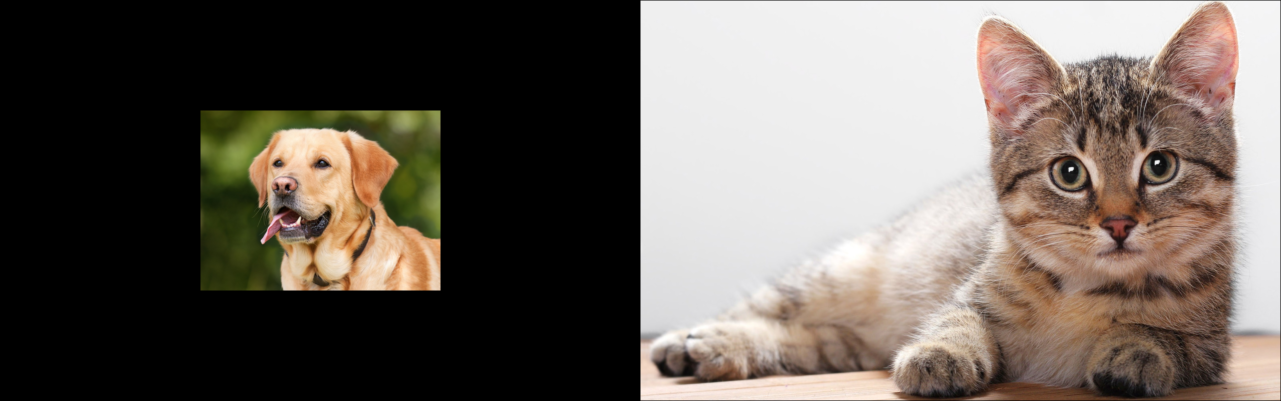

In [34]:
test_single_image_1_path = "../data/catsndogs/single_prediction/cat_or_dog_1.jpg"
test_single_image_2_path = "../data/catsndogs/single_prediction/cat_or_dog_2.jpg"

test_single_image_1 = load_test_image(test_single_image_1_path)
test_single_image_2 = load_test_image(test_single_image_2_path)
@show size(test_single_image_1)
@show size(test_single_image_2)

img1 = Images.load(test_single_image_1_path)
img2 = Images.load(test_single_image_2_path)
mosaicview(img1, img2; nrow=1)

In [35]:
function convert_dogcat(result)
    return map(x ->  x > 0.5 ? "dog" : "cat", result)
end

convert_dogcat (generic function with 1 method)

In [0]:
@show size(reshape(test_single_image_1, (size(test_single_image_1)..., 1)))

In [49]:
single_predict_1 = model(reshape(test_single_image_1, (size(test_single_image_1)..., 1)))
convert_dogcat(single_predict_1)

1×1 Matrix{String}:
 "dog"

In [37]:
single_predict_2 = model(reshape(test_single_image_2, (size(test_single_image_2)..., 1)))
convert_dogcat(single_predict_2)

1×1 Matrix{String}:
 "cat"

### Combine them together

In [38]:
batch_array = cat(reshape(test_single_image_1, (size(test_single_image_1)..., 1)), reshape(test_single_image_2, (size(test_single_image_2)..., 1)), dims=4)

64×64×3×2 Array{Float32, 4}:
[:, :, 1, 1] =
 0.211765  0.188235  0.188235  0.180392  …  0.180392  0.196078  0.207843
 0.227451  0.2       0.188235  0.176471     0.164706  0.164706  0.168627
 0.25098   0.227451  0.215686  0.188235     0.14902   0.172549  0.192157
 0.278431  0.258824  0.231373  0.2          0.180392  0.188235  0.203922
 0.282353  0.278431  0.239216  0.203922     0.180392  0.184314  0.196078
 0.282353  0.266667  0.239216  0.207843  …  0.168627  0.180392  0.176471
 0.266667  0.25098   0.223529  0.203922     0.176471  0.184314  0.180392
 0.247059  0.235294  0.203922  0.211765     0.188235  0.188235  0.196078
 0.219608  0.203922  0.203922  0.203922     0.180392  0.180392  0.203922
 0.196078  0.2       0.203922  0.2          0.172549  0.184314  0.2
 0.176471  0.184314  0.2       0.207843  …  0.164706  0.168627  0.192157
 0.188235  0.203922  0.223529  0.247059     0.152941  0.160784  0.192157
 0.207843  0.219608  0.254902  0.278431     0.160784  0.188235  0.235294
 ⋮          

In [39]:
batch_results = convert_dogcat(model(batch_array))

1×2 Matrix{String}:
 "dog"  "cat"

### Evaluate Test Set